# ETL Part 2 — Feature Engineering & ML Preparation

# Overview

* Feature Engineering & ML Prep — Bank Marketing

This notebook takes `data/cleaned_bank.csv` and prepares an **ML-ready** dataset.  
Focus: **feature engineering → encoding → scaling → save ML data → baseline model & evaluation**.  
We **exclude** `duration` from modelling to avoid leakage (it’s only known after the call).

# 1- Import required libraries

In [1]:
%pip install scikit-learn

# --- Imports ---
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Display settings (optional)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.float_format", "{:,.2f}".format)

Note: you may need to restart the kernel to use updated packages.


# 2- Load cleaned dataset

In [2]:
# --- Load cleaned data ---
df = pd.read_csv("../data/cleaned_bank.csv")
print("Loaded cleaned data:", df.shape)
df.head()

Loaded cleaned data: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


# 3-  Feature Engineering

Create helpful features (no saving yet):
- `was_previously_contacted` from `pdays`
- `age_band` (if missing), `has_any_loan`, `call_intensity`
- `pdays_bucket` (recent contact buckets)
- `month_index`, cyclic month (`month_sin`, `month_cos`)
- `balance_per_age`
Exclude **`duration`** from modelling to prevent leakage.

In [3]:
df_fe = df.copy()

# Ensure/refresh prior-contact flag
if "pdays" in df_fe.columns:
    df_fe["was_previously_contacted"] = df_fe["pdays"].apply(lambda x: 0 if x == -1 else 1).astype("Int64")

# Age band if missing
if "age" in df_fe.columns and "age_band" not in df_fe.columns and pd.api.types.is_numeric_dtype(df_fe["age"]):
    df_fe["age_band"] = pd.cut(
        df_fe["age"], bins=[0, 25, 35, 50, 65, 120],
        labels=["<25", "25-34", "35-49", "50-64", "65+"]
    )

# Normalise housing/loan if still object (safety)
for c in ["housing", "loan"]:
    if c in df_fe.columns and df_fe[c].dtype == "object":
        df_fe[c] = df_fe[c].str.strip().str.lower().map({"yes": 1, "no": 0, "unknown": pd.NA}).astype("Int64")

# Any-loan flag
if set(["housing", "loan"]).issubset(df_fe.columns):
    df_fe["has_any_loan"] = (
        df_fe[["housing", "loan"]].fillna(0).sum(axis=1).clip(upper=1).astype("Int64")
    )

# Call intensity ratio (campaign / (previous + 1))
if "campaign" in df_fe.columns and "previous" in df_fe.columns:
    df_fe["call_intensity"] = df_fe["campaign"] / (df_fe["previous"] + 1)

# pdays buckets
if "pdays" in df_fe.columns:
    def pdays_bucket(x):
        if x == -1: return "never"
        if x <= 7:  return "≤7d"
        if x <= 30: return "8–30d"
        if x <= 90: return "31–90d"
        return ">90d"
    df_fe["pdays_bucket"] = df_fe["pdays"].apply(pdays_bucket)

# Month index + cyclic encoding
month_order = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
if "month" in df_fe.columns:
    m = df_fe["month"].astype(str).str.strip().str.lower()
    df_fe["month_index"] = m.map({m:i+1 for i,m in enumerate(month_order)})

if "month_index" in df_fe.columns:
    df_fe["month_sin"] = np.sin(2 * np.pi * (df_fe["month_index"].fillna(0) / 12))
    df_fe["month_cos"] = np.cos(2 * np.pi * (df_fe["month_index"].fillna(0) / 12))

# Balance per age
if set(["balance", "age"]).issubset(df_fe.columns) and pd.api.types.is_numeric_dtype(df_fe["age"]):
    df_fe["balance_per_age"] = df_fe["balance"] / (df_fe["age"].replace(0, np.nan))

# Features to exclude (leakage / not useful)
features_to_exclude = []
if "duration" in df_fe.columns:
    features_to_exclude.append("duration")  # known post-call only

print("Engineered columns added:", sorted(set(df_fe.columns) - set(df.columns)))

# Save feature-engineered dataset
df_fe.to_csv("../data/feature_engineered.csv", index=False)


Engineered columns added: ['age_band', 'balance_per_age', 'call_intensity', 'has_any_loan', 'month_cos', 'month_index', 'month_sin', 'pdays_bucket', 'was_previously_contacted']


# 4- Data Encoding

Prepare features and target:
- Separate **X** (features) and **y** (target).
- Identify categorical vs numeric fields.
- Impute and **one-hot encode** categorical variables.
(Scaling of numeric features happens in the next section.)

In [4]:
# --- Identify target column ---
print("Columns in your DataFrame:", df_fe.columns.tolist())

# Try to auto-detect the target column if 'y' is missing
possible_targets = [col for col in df_fe.columns if col.lower() in ["y", "target", "subscribed", "response", "deposit"]]
if possible_targets:
    target_col = possible_targets[0]
    print(f"Using '{target_col}' as the target column.")
else:
    # If not found, set manually:
    target_col = "y"  # <-- change this if your target column is named differently

if target_col not in df_fe.columns:
    raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

# --- Prepare features and target ---
y = df_fe[target_col]
if y.dtype == "O":
    # Try to map yes/no to 1/0 if needed
    y = y.map({"yes": 1, "no": 0}).fillna(y).astype(int)

X = df_fe.drop(columns=[target_col] + features_to_exclude, errors="ignore")

# --- Identify feature types ---
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# --- Impute categorical then One-Hot encode ---
cat_imputer = SimpleImputer(strategy="most_frequent")
X_cat_imputed = pd.DataFrame(
    cat_imputer.fit_transform(X[categorical_features]),
    columns=categorical_features,
    index=X.index
)

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat_encoded = pd.DataFrame(
    ohe.fit_transform(X_cat_imputed),
    columns=ohe.get_feature_names_out(categorical_features),
    index=X.index
)

# --- Numeric imputation only (scaling next) ---
num_imputer = SimpleImputer(strategy="median")
X_num_imputed = pd.DataFrame(
    num_imputer.fit_transform(X[numeric_features]),
    columns=numeric_features,
    index=X.index
)

print("Encoded categorical shape:", X_cat_encoded.shape)
print("Imputed numeric shape:", X_num_imputed.shape)

# --- Combine all features for ML ---
X_final = pd.concat([X_num_imputed, X_cat_encoded], axis=1)

# --- Optional: Train/test split and simple ML baseline ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Columns in your DataFrame: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'was_previously_contacted', 'age_band', 'has_any_loan', 'call_intensity', 'pdays_bucket', 'month_index', 'month_sin', 'month_cos', 'balance_per_age']
Using 'deposit' as the target column.
Numeric features: ['age', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays', 'previous', 'was_previously_contacted', 'has_any_loan', 'call_intensity', 'month_index', 'month_sin', 'month_cos', 'balance_per_age']
Categorical features: ['job', 'marital', 'education', 'default', 'contact', 'month', 'poutcome', 'age_band', 'pdays_bucket']
Encoded categorical shape: (11162, 50)
Imputed numeric shape: (11162, 15)
Accuracy: 0.6851768920734438
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.77      0.72      1175
           1       0.70      0.

/Users/aminaibrahim/Documents/vscode-projects/capstone-bank-marketing-analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 5- Scaling numerical features

Apply **StandardScaler** to numeric variables, then combine with encoded categoricals  
to form a single **ML-ready** feature table.

In [5]:
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num_imputed),
    columns=numeric_features,
    index=X_num_imputed.index
)

# Concatenate scaled numeric + encoded categoricals
X_ready = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
print("ML-ready feature table:", X_ready.shape)
X_ready.head(3)

ML-ready feature table: (11162, 65)


,age,balance,housing,loan,day,campaign,pdays,previous,was_previously_contacted,has_any_loan,call_intensity,month_index,month_sin,month_cos,balance_per_age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_band_25-34,age_band_35-49,age_band_50-64,age_band_65+,age_band_<25,pdays_bucket_31–90d,pdays_bucket_8–30d,pdays_bucket_>90d,pdays_bucket_never,pdays_bucket_≤7d
0,1.49,0.25,1.06,-0.39,-1.27,-0.55,-0.48,-0.36,-0.58,0.94,-0.42,-0.46,0.75,-0.73,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,1.24,-0.46,-0.95,-0.39,-1.27,-0.55,-0.48,-0.36,-0.58,-1.06,-0.42,-0.46,0.75,-0.73,-0.49,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,-0.02,-0.08,1.06,-0.39,-1.27,-0.55,-0.48,-0.36,-0.58,0.94,-0.42,-0.46,0.75,-0.73,-0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


# 6-  Save the ML-ready dataset

Persist the final feature matrix and target for reuse in modelling notebooks.
Output: `../data/ml_ready_bank.csv` (features + `y`)

In [6]:
# Ensure data/ exists and save
os.makedirs("data", exist_ok=True)

ml_ready = X_ready.copy()
ml_ready.insert(0, "y", y.values)  # put target as first column

out_path = os.path.join("data", "ml_ready_bank.csv")
ml_ready.to_csv(out_path, index=False)

print(f"Saved ML-ready dataset to: {out_path}")
print("Shape:", ml_ready.shape)

Saved ML-ready dataset to: data/ml_ready_bank.csv
Shape: (11162, 66)


# 7- Basic evaluation & modelling (Logistic Regression)

Basic Evaluation & Modelling (Logistic Regression)
Train a simple baseline classifier:
- Stratified train/test split
- Logistic Regression
- Metrics: Accuracy, Precision, Recall, F1, ROC-AUC

Accuracy : 0.700
Precision: 0.744
Recall   : 0.559
F1-score : 0.638
ROC AUC  : 0.763

Classification report:
              precision    recall  f1-score   support

           0      0.675     0.827     0.744      1175
           1      0.744     0.559     0.638      1058

    accuracy                          0.700      2233
   macro avg      0.710     0.693     0.691      2233
weighted avg      0.708     0.700     0.694      2233

Confusion matrix:
 [[972 203]
 [467 591]]


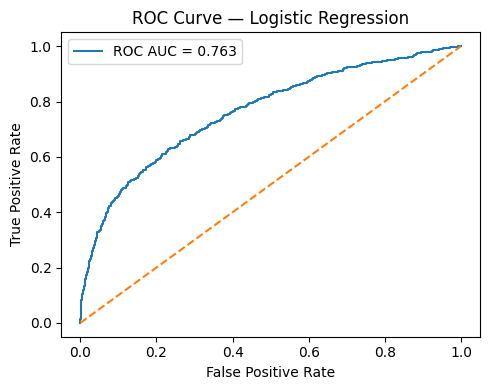

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_ready, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions & metrics
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {roc:.3f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ROC curve (optional)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# 8- Conclusion & Next Steps 

## Conclusion

In this notebook, we extended the ETL process by engineering additional features, encoding categorical variables, and scaling numerical features to prepare the dataset for machine learning.

Key outcomes:
- Loaded and enhanced `../data/cleaned_bank.csv` with new derived variables to improve analytical depth.
- Encoded categorical variables and scaled numeric variables for model compatibility.
- Created and saved an **ML-ready** dataset as `../data/ml_ready_bank.csv`.
- Built a baseline Logistic Regression model to establish initial performance benchmarks.

The dataset is now fully prepped for in-depth modelling, exploratory analysis, and dashboard creation.

## Next Steps

1. **Modelling**  
   - Build and evaluate two predictive models:  
     - **Logistic Regression** (baseline, already tested here)  
     - **Random Forest Classifier** (handles non-linear relationships, robust to mixed data types)  
   - Compare performance metrics and examine feature importance.

2. **Exploratory Data Analysis (EDA)**  
   - Perform statistical summaries, correlation checks, and pattern identification.  
   - Investigate relationships between features and the target variable.

3. **Data Visualisation (Tableau)**  
   - Develop an interactive dashboard with at least four distinct plot types to address business questions.  
   - Include filters and clear labels for both technical and non-technical users.

4. **Ethics & Data Governance**  
   - Assess privacy, bias, and fairness concerns within the dataset.  
   - Review compliance with relevant regulations (e.g., GDPR).

5. **Project Documentation**  
   - Update the README with methodology, findings, visualisations, and conclusions.  
   - Ensure full reproducibility and clarity for all project assets.

## References:
OpenAI. (2025). ChatGPT. https://chat.openai.com
GitHub. (2025). GitHub Copilot. https://github.com/features/copilot